In [99]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.colors as colors

## Define locations

In [8]:
BASEURI = 'gs://fdl2023-sar-datasets'
AOI     = "conus"
AOIURI  = f"{BASEURI}/{AOI}"

## Find and download definition files

observe that there are two files

- one defining the chips and their boundaries
- one splitting chips in three splits which reduce spatial data leakage

we do it this way since usually you just want to know what split a certain chip is in without having to load all the boundary definitions which are relatively large.

**MAKE SURE `gsutil` IS INSTALLED AND CONFIGURE IN YOUR SYSTEM!!!**

In [19]:
files = !gsutil ls $AOIURI

chipdefs_file  = [i for i in files if i.endswith(".geojson") and 'partitions_aschips' in i][0]
splitdefs_file = [i for i in files if i.endswith(".csv") and '_splits_' in i][0]
print (f"using chip  definitions at {chipdefs_file}")
print (f"using split definitions at {splitdefs_file}")

using chip  definitions at gs://fdl2023-sar-datasets/conus/conus_partitions_aschips_293d95e3ee589.geojson
using split definitions at gs://fdl2023-sar-datasets/conus/conus_partitions_aschips_293d95e3ee589_splits_60bands_angle09_60-20-20.csv


In [101]:
!gsutil cp -nc $chipdefs_file data
!gsutil cp -nc $splitdefs_file data
!ls -las data

Skipping existing item: file://data/conus_partitions_aschips_293d95e3ee589.geojson
Skipping existing item: file://data/conus_partitions_aschips_293d95e3ee589_splits_60bands_angle09_60-20-20.csv
total 66592
    4 drwxrwxr-x 2 rlx rlx     4096 Dec  3 20:31 .
    4 drwxrwxr-x 5 rlx rlx     4096 Dec  3 20:34 ..
63404 -rw-rw-r-- 1 rlx rlx 64918760 Dec  3 20:03 conus_partitions_aschips_293d95e3ee589.geojson
 3176 -rw-rw-r-- 1 rlx rlx  3249458 Dec  3 20:03 conus_partitions_aschips_293d95e3ee589_splits_60bands_angle09_60-20-20.csv
    4 -rw-rw-r-- 1 rlx rlx      879 Dec  3 20:21 massachusetts.wkt


## Load chip definitions

Observe that each chips has a unique identifier and a polygon defining it

In [35]:
chipdefs_localfile = f"data/{chipdefs_file.split('/')[-1]}"
splitdefs_localfile = f"data/{splitdefs_file.split('/')[-1]}"
c = gpd.read_file(chipdefs_localfile)
s = pd.read_csv(splitdefs_localfile, index_col=0)

In [38]:
c.shape, s.shape

((167406, 3), (167406, 1))

In [36]:
c.head()

,area_km2,identifier,geometry
0,21.933822,0127acc7072b4,"POLYGON ((-124.33567 40.19860, -124.33567 40.2..."
1,21.939105,28225af8c635c,"POLYGON ((-124.35024 40.23508, -124.35024 40.2..."
2,21.944403,12f2787fa918c,"POLYGON ((-124.36484 40.27155, -124.36484 40.3..."
3,21.949715,36566329c2021,"POLYGON ((-124.37946 40.30801, -124.37946 40.3..."
4,21.955041,27a3b9cd6d88f,"POLYGON ((-124.39411 40.34447, -124.39411 40.3..."


In [37]:
s.head()

,split
identifier,
0127acc7072b4,train
28225af8c635c,train
12f2787fa918c,train
36566329c2021,train
27a3b9cd6d88f,train


## Visualize chips

since there are many chips, we sample a few for the visualization widget not to become too slugish

In [41]:
c.sample(1000).explore()

## Select the chips of an area

we load the boundaries of Massachusetts and select the chips intersecting with it

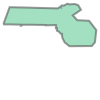

In [70]:
with open("data/massachusetts.wkt", "r") as f:
    bounds = wkt.load(f)
bounds

In [71]:
myarea = c[[bounds.intersects(g) for g in c.geometry]]
myarea.shape

(1285, 3)

In [73]:
myarea.explore()

## Inspect train, test and val splits in this area

we merge with the split definitions, count how many chips on each split, and plot it

In [97]:
myarea_splits = myarea.merge(s, left_on='identifier', right_on='identifier')
myarea_splits.split.value_counts()

val      709
test     344
train    232
Name: split, dtype: int64

In [100]:
myarea_splits.explore(column='split', cmap=colors.ListedColormap(['red','blue', 'green']))